Contents of this notebook:

   1. [Library loading and installation](#1)
   2. [How does the number of ratings affect the rating of a book?](#2)
   3. [Preprocessing](#3)
   4. [Ordinary Least Squares Linear Regression](#4)
   5. [Ridge Regression](#5)
   6. [Lasso](#6)
  
       6.1. [Normalizing the data](#7)
       
       6.2. [LassoLarsIC](#8)
       
       6.3. [LassoCV](#9)
       
       6.4. [LassoLarsCV](#10)
   7. [Elastic-Net](#11)

Citation

[Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

[API design for machine learning software: experiences from the scikit-learn project](https://arxiv.org/abs/1309.0238), Buitinck et al., 2013.

> # 1. Library loading and installation<a id="1"></a>

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import powerlaw
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, lasso_path, enet_path, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import time
from itertools import cycle

In [2]:
pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-py3-none-any.whl size=24787 sha256=31e744fb6426a3d46903f408feb9a20836e912f5a6593a629a8fe306be753976
  Stored in directory: /root/.cache/pip/wheels/ee/51/38/2e0f20cf80e1a0909acdd527df2288bd9feb8356b926d7d775
Successfully built powerlaw
Note: you may need to restart the kernel to use updated packages.


In [3]:
import powerlaw

In [4]:
books = pd.read_csv("../input/goodreadsbooks/books.csv", error_bad_lines = False)
books.rename(columns={"  num_pages":'num_pages'}, inplace=True)
books.head()

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


> # 2. How does the number of ratings affect the rating of a book?<a id="2"></a>

First sort the books by the number of ratings.

In [5]:
books.sort_values(by='ratings_count')

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
9847,39580,The American Campaign: U.S. Presidential Campa...,James E. Campbell,5.00,089096940X,9780890969403,eng,314,0,0,5/1/2000,Texas A&M University Press
7634,29404,Your Child and Jesus: A Family Activity Book,Rick Osborne/Kevin Miller,0.00,080242855X,9780802428554,eng,112,0,0,9/13/1999,Moody Publishers
10917,44705,The Leadership Challenge: Skills for Taking Ch...,Warren G. Bennis,0.00,088684049X,9780886840495,eng,60,0,0,12/1/1985,AMR/Advanced Management Reports
3492,12712,Brodie's notes on Aldous Huxley's brave new world,Graham Handley,0.00,0333581296,9780333581292,eng,71,0,0,8/20/1992,Macmillan
10442,42489,After Collapse: The Regeneration of Complex So...,Glenn M. Schwartz,4.00,0816525099,9780816525096,eng,336,0,0,5/25/2006,University of Arizona Press
...,...,...,...,...,...,...,...,...,...,...,...,...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
307,960,Angels & Demons (Robert Langdon #1),Dan Brown,3.89,1416524797,9781416524793,eng,736,2418736,21303,4/1/2006,Pocket Books
1462,5107,The Catcher in the Rye,J.D. Salinger,3.80,0316769177,9780316769174,eng,277,2457092,43499,1/30/2001,Back Bay Books
1697,5907,The Hobbit or There and Back Again,J.R.R. Tolkien,4.27,0618260307,9780618260300,eng,366,2530894,32871,8/15/2002,Houghton Mifflin


Get the maximum of the number of ratings.


In [6]:
max_ratings_count = np.max(books.ratings_count)
max_ratings_count

4597666

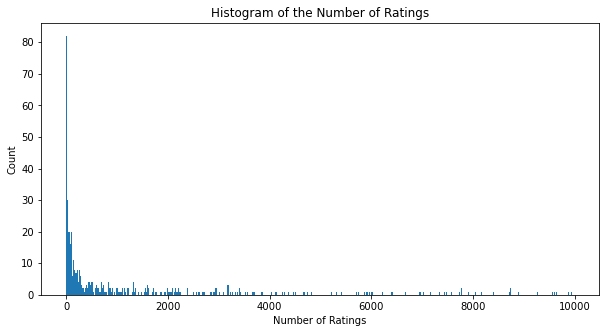

In [7]:
# histogram of number of ratings
ratings = books.ratings_count.loc[books.ratings_count < 10000] # >= 10000 outliers
plt.figure(figsize=(10, 5))
plt.hist(ratings, bins=10000)
plt.title('Histogram of the Number of Ratings')
plt.ylabel('Count')
plt.xlabel('Number of Ratings')
plt.show()

A sign of power law distribution. Although the maximum ratings count is 4 million, actual rating counts exceeding 10000 are insignificant.

Power Law Distribution

/opt/conda/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha=  1.1551164823229938   sigma=  0.00162046294357727


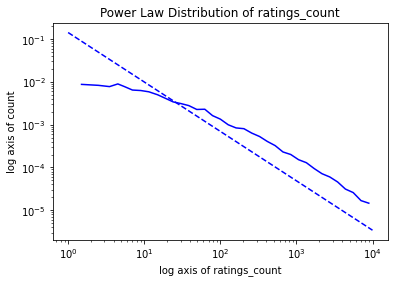

In [8]:
fit = powerlaw.Fit(ratings+1,xmin=1,discrete=True)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.title('Power Law Distribution of ratings_count')
plt.xlabel('log axis of ratings_count')
plt.ylabel('log axis of count')
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

How does the flunctuation look like?

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


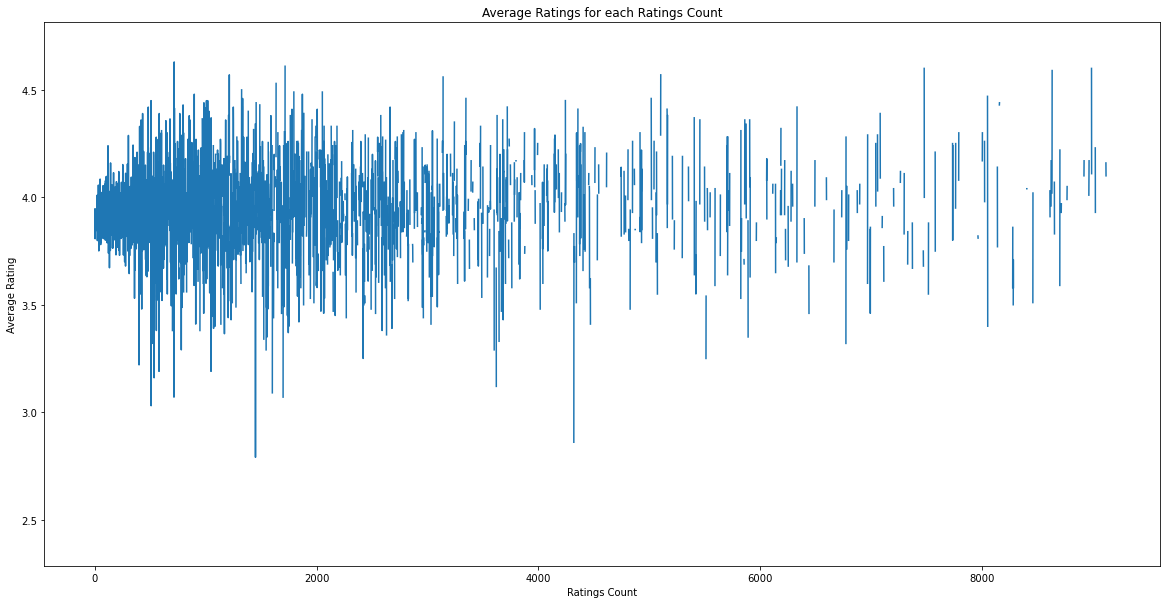

In [9]:
ave_ratings = []
for i in range(1, len(ratings)):
    rating = books.average_rating[books.ratings_count == i].values.astype(float)
    ave_ratings.append(np.average(rating))
plt.figure(figsize=(20, 10))
plt.plot(ave_ratings)
plt.title('Average Ratings for each Ratings Count')
plt.xlabel('Ratings Count')
plt.ylabel('Average Rating')
plt.show()

The ratings count does not seem to have a strong effect in the mean of the average rating. However, it does reduce the flunctuation, i.e., the variance, of the average ratings, as the ratings count increases.

In [10]:
ave_ratings = np.array(ave_ratings)
ave_ratings = ave_ratings[ave_ratings >= 0]
average_rating = np.average(ave_ratings)
print('The average rating of all books: ' + '%.2f' % average_rating)

The average rating of all books: 3.95


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


> # 3. Preprocessing<a id='3'></a>

Only ratings_count, num_pages and text_reviews_count are taken as features.


In [11]:
# Overall fitting
X = books.loc[0:, ['ratings_count', 'num_pages', 'text_reviews_count']].values.astype(float)
y = books.average_rating.values.astype(float)

books.sort_values(by='bookID')
books = books.loc[books.ratings_count < 7000] # >= 7000 outliers

# Training and prediction
train_X = books.loc[0:8000, ['ratings_count', 'num_pages', 'text_reviews_count']].values.astype(float)
train_y = books.loc[0:8000, ['average_rating']].values.astype(float)
test_X = books.loc[8000:, ['ratings_count', 'num_pages', 'text_reviews_count']].values.astype(float)
test_y = books.loc[8000:, ['average_rating']].values.astype(float)

> # 4. Linear Regression<a id="4"></a>

In [12]:
reg = linear_model.LinearRegression()
reg.fit(X, y)

# The coefficients of each of these features.
print('Regression Coefficients:')
print(reg.coef_)
print('Interception:')
print(reg.intercept_)

Regression Coefficients:
[ 1.08709020e-07  2.17069264e-04 -2.82486437e-07]
Interception:
3.8592546046184726


Regression Coefficients:
[[ 3.85588142e-05  2.03061005e-04 -5.00496960e-04]]
Interception:
[3.85357906]
Mean Squared Error:
0.1347529071737306
r2 score:
0.02805247688782131
Sum of Squared Errors:
346.1802185293139


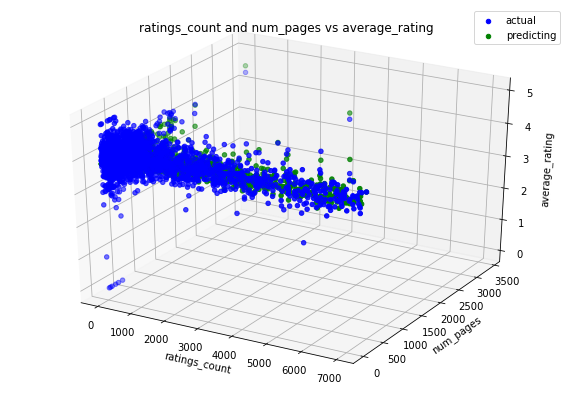

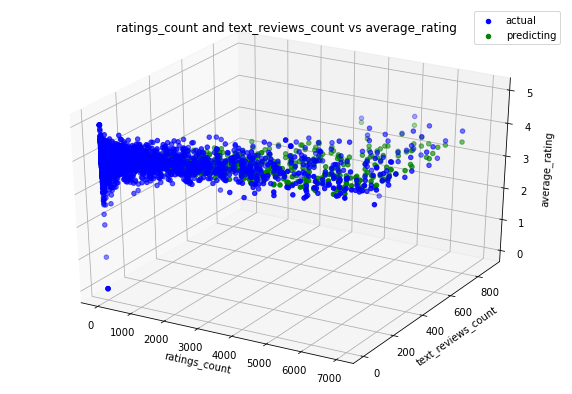

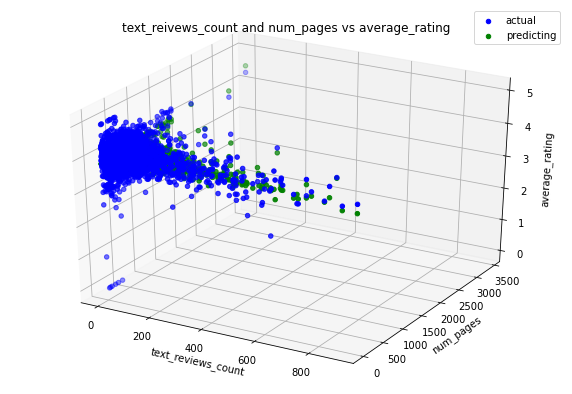

In [13]:
reg.fit(train_X, train_y)

print('Regression Coefficients:')
print(reg.coef_)
print('Interception:')
print(reg.intercept_)

pred_y = reg.predict(test_X)

print('Mean Squared Error:')
print(mean_squared_error(test_y, pred_y))

print('r2 score:')
print(r2_score(test_y, pred_y))

print('Sum of Squared Errors:')
print(np.sum(np.square(pred_y - test_y)))

fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 
ax.scatter3D(test_X[:, 0], test_X[:, 1], test_y, color = "b")
plt.title("ratings_count and num_pages vs average_rating")
ax.set_xlabel("ratings_count")
ax.set_ylabel("num_pages")
ax.set_zlabel("average_rating")
ax.scatter3D(test_X[:, 0], test_X[:, 1], pred_y, color = "green")
ax.legend(['actual', 'predicting'])

plt.show()

fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 
ax.scatter3D(test_X[:, 0], test_X[:, 2], test_y, color = "b")
plt.title("ratings_count and text_reviews_count vs average_rating")
ax.set_xlabel("ratings_count")
ax.set_ylabel("text_reviews_count")
ax.set_zlabel("average_rating")
ax.scatter3D(test_X[:, 0], test_X[:, 2], pred_y, color = "green")
ax.legend(['actual', 'predicting'])

plt.show()

fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 
ax.scatter3D(test_X[:, 2], test_X[:, 1], test_y, color = "b")
plt.title("text_reivews_count and num_pages vs average_rating")
ax.set_xlabel("text_reviews_count")
ax.set_ylabel("num_pages")
ax.set_zlabel("average_rating")
ax.scatter3D(test_X[:, 2], test_X[:, 1], pred_y, color = "green")
ax.legend(['actual', 'predicting'])

plt.show()

Linear regression with features num_pages, text_reviews_count and ratings_count leaves a high variance unexplained, indicated by a low R2-score.

> # 5. Ridge Regression<a id="5"></a>

In ridge regression, penalty on the size of the coefficients is present in order to counterbalance collinearity.
See https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification for reference.

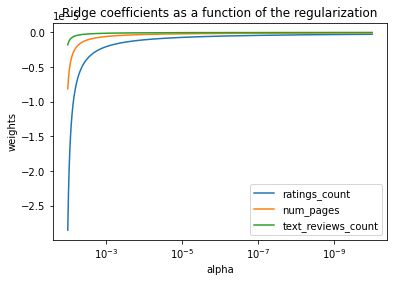

In [14]:
ran = range(-100000000000000, -999999900000) # range of alpha
ran = ran[0::10000000000] # Reduce runtime and memory.
alphas = np.logspace(-10, -2, len(ran))
coefs = []
r2s = []
mses = []

for a in ran:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(train_X, train_y)
    pred_y = reg.predict(test_X)
    
    coefs.append(ridge.coef_[0])
    mses.append(mean_squared_error(test_y, pred_y))
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(['ratings_count', 'num_pages', 'text_reviews_count'])
plt.axis('tight')
plt.show()

The balance point between a presumably high collinearity and an over-dominating regularization is 10^-5.

The mean squared error and r2 do not change, however.

In [15]:
print('Mean Squared Error:')
print(mean_squared_error(test_y, pred_y))

print('r2 score:')
print(r2_score(test_y, pred_y))

print('Sum of Squared Errors:')
print(np.sum(np.square(pred_y - test_y)))

Mean Squared Error:
0.1347529071737306
r2 score:
0.02805247688782131
Sum of Squared Errors:
346.1802185293139


> # 6. Lasso<a id='6'><a/>

Objective function:

$min_w\frac{1}{2n}\rVert Xw-y\rVert^2+\alpha\rVert w\rVert$

In [16]:
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-9

> # 6.1. Normalizing the data<a id='7'></a>

In [17]:
X /= np.sqrt(np.sum(X ** 2, axis=0))

> # 6.2. LassoLarsIC: least angle regression with BIC/AIC criterion<a id='8'></a>

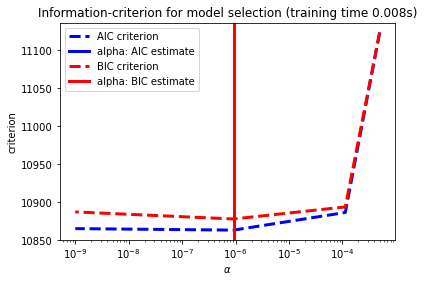

In [18]:
reg_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
reg_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = reg_bic.alpha_

reg_aic = LassoLarsIC(criterion='aic')
reg_aic.fit(X, y)
alpha_aic_ = reg_aic.alpha_

def plot_ic_criterion(reg, name, color):
    criterion_ = reg.criterion_
    plt.semilogx(reg.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(reg.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure()
plot_ic_criterion(reg_aic, 'AIC', 'b')
plot_ic_criterion(reg_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)
plt.show()

> # 6.3. LassoCV: coordinate descent<a id='9'></a>

Computing regularization path using the coordinate descent lasso...


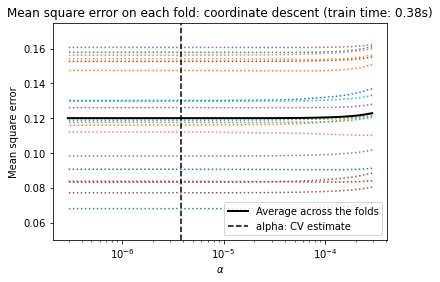

In [19]:
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
reg = LassoCV(cv=20).fit(X, y) # 20-fold cross-validation
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 0.05, 0.175
plt.semilogx(reg.alphas_ + EPSILON, reg.mse_path_, ':')
plt.plot(reg.alphas_ + EPSILON, reg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(reg.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)
plt.show()

> # 6.4. LassoLarsCV: least angle regression <a id='10'></a>

Computing regularization path using the Lars lasso...


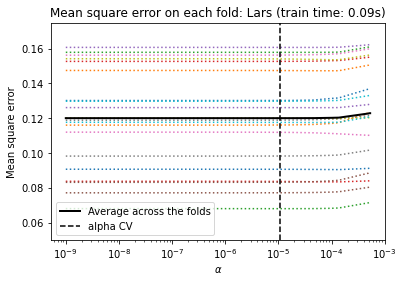

In [20]:
# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
reg = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(reg.cv_alphas_ + EPSILON, reg.mse_path_, ':')
plt.semilogx(reg.cv_alphas_ + EPSILON, reg.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
plt.axvline(reg.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

> # 7. Elastic-Net<a id='11'></a>

Objective function:

$min_w\frac{1}{2n}\rVert Xw-y\rVert^2+\alpha\rho\rVert w\rVert+\frac{\alpha(1-\rho)}{2}\rVert w\rVert^2$

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


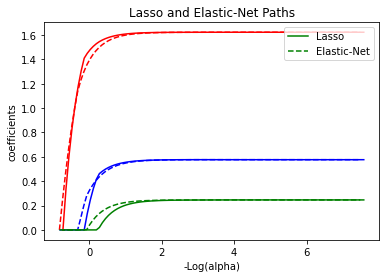

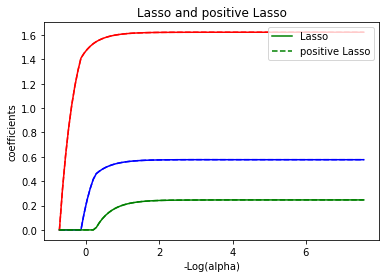

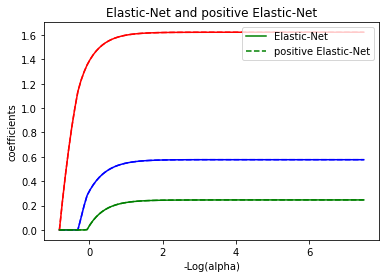

In [21]:
X = books.loc[0:, ['ratings_count', 'num_pages', 'text_reviews_count']].values.astype(float)
y = books.average_rating.values.astype(float)

def plot_path(X):
    X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

    # Compute paths

    eps = 5e-9  # the smaller it is the longer is the path

    print("Computing regularization path using the lasso...")
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False)

    print("Computing regularization path using the positive lasso...")
    alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
        X, y, eps=eps, positive=True, fit_intercept=False)
    print("Computing regularization path using the elastic net...")
    alphas_enet, coefs_enet, _ = enet_path(
        X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

    print("Computing regularization path using the positive elastic net...")
    alphas_positive_enet, coefs_positive_enet, _ = enet_path(
        X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

    # Display results

    colors = cycle(['b', 'r', 'g'])
    plt.figure(1)
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
        l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso and Elastic-Net Paths')
    plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='upper right')
    plt.axis('tight')


    plt.figure(2)
    neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
    for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
        l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso and positive Lasso')
    plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='upper right')
    plt.axis('tight')


    plt.figure(3)
    neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
    for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
        l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Elastic-Net and positive Elastic-Net')
    plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
               loc='upper right')
    plt.axis('tight')
    plt.show()
    
plot_path(X)